### **Emotion Detection**

**Importing Libraries**

In [9]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


**Exploring Dataset**

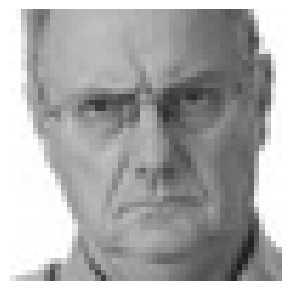

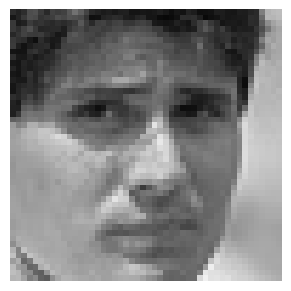

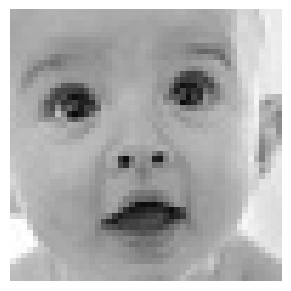

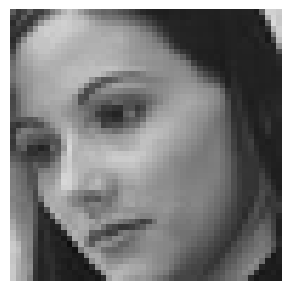

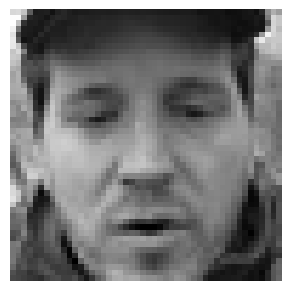

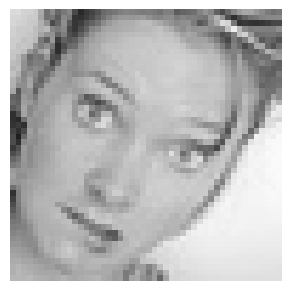

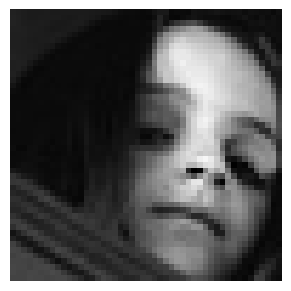

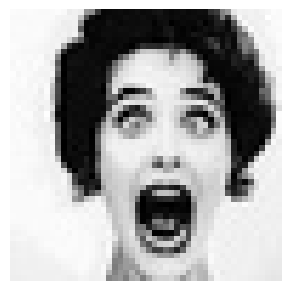

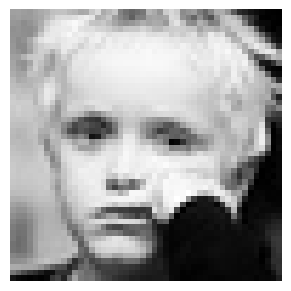

In [10]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data for Training**

In [22]:
img_size = 48
batch_size =64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size), 
                                                    color_mode = "grayscale", 
                                                    batch_size = batch_size, 
                                                    class_mode = "categorical", 
                                                    shuffle = True)
datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size), 
                                                    color_mode = "grayscale", 
                                                    batch_size = batch_size, 
                                                    class_mode = "categorical", 
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [23]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size= kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [24]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [25]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32,(3,3))
    conv_2 = Convolution(inputs, 64,(5,5))
    conv_3 = Convolution(inputs, 128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten, 256)

    output = Dense(7, activation = "softmax")(dense_1)
    model = Model(inputs= [inputs], outputs = [output])

    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])

    return model

In [26]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

**Initialzing the Model**

In [29]:
epochs =15
steps_per_epoch =  train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

### **Training the Model**

**The next cell takes time to complete**

In [33]:
history = model.fit(
x=train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks =callbacks)

Epoch 1/15


C:\Users\GT\anaconda3\envs\emotion_detection_course\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.3248 - loss: 1.8213
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 349s 770ms/step - accuracy: 0.3249 - loss: 1.8209 - val_accuracy: 0.4216 - val_loss: 1.5168
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:02 408ms/step - accuracy: 0.4688 - loss: 1.3434
Epoch 2: saving model to model_weights.weights.h5


C:\Users\GT\anaconda3\envs\emotion_detection_course\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - accuracy: 0.4688 - loss: 1.3434 - val_accuracy: 0.2000 - val_loss: 1.5207
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.4842 - loss: 1.3569
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 190s 424ms/step - accuracy: 0.4842 - loss: 1.3569 - val_accuracy: 0.3502 - val_loss: 1.6079
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:11 429ms/step - accuracy: 0.5156 - loss: 1.3912
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.5156 - loss: 1.3912 - val_accuracy: 0.3000 - val_loss: 1.9196
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.5620 - loss: 1.1802
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 195s 434ms/step - accuracy: 0.5620 - loss: 1.1803 - val_accuracy: 0.4083 - val_loss: 1.6371
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:16 440ms/step - accuracy: 0.6562 - loss: 0.9536
Epoch 6: savin

**Model Evaluation**

In [46]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.4387 - loss: 1.7634


[1.7495276927947998, 0.4465031921863556]

**Plotting Loss**

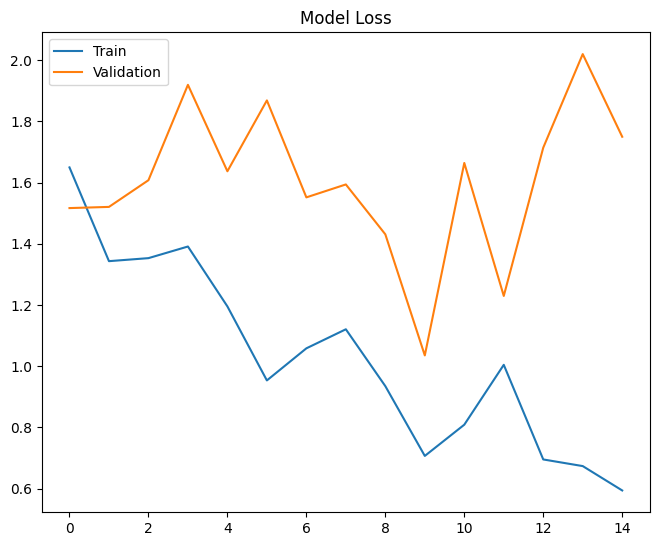

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25,wspace=0.35)

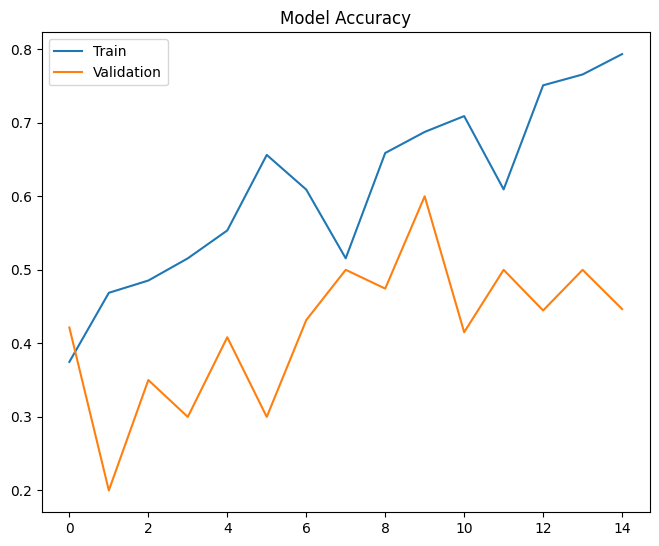

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25,wspace=0.35)

**Saving Model**

In [45]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)